# Portfolio Contrusction for Q4.2023 

# 1. Identifying Stock Universe

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
#read csv file of tech stocks on NASDAQ Exchange and NYSE Exchange
nasdaq_stock = pd.read_csv('nasdaq.csv')
nyse_stock = pd.read_csv('nyse.csv')

In [3]:
#Concatenate 2 files and extract all symbols
tech_stocks = pd.concat([nasdaq_stock, nyse_stock], ignore_index = True)
tech_stocks_list = tech_stocks['Symbol']

In [4]:
print(tech_stocks_list)

0      AAPL
1      ACIW
2      ACLS
3      ADBE
4       ADI
       ... 
287     WIT
288      WK
289    WOLF
290     YMM
291     YOU
Name: Symbol, Length: 292, dtype: object


In [5]:
# Check for duplicates whether a stock traded on both exchanges
has_duplicates = len(tech_stocks_list) != len(set(tech_stocks_list))

if has_duplicates:
    print("The list contains duplicate values.")
else:
    print("The list does not contain any duplicates.")

The list does not contain any duplicates.


In [6]:
#Filter the companies which release quarterly financial statement and has 2 latest quarterly financial statements
tech_list = []
date_q4 = pd.to_datetime('2023-09-30 00:00:00')
date_q3 = pd.to_datetime('2023-06-30 00:00:00')
for symbol in tech_stocks_list:
    balance_sheet_cols = yf.Ticker(symbol).quarterly_balancesheet.columns
    financials_cols = yf.Ticker(symbol).quarterly_financials.columns
    cashflow_cols = yf.Ticker(symbol).quarterly_cashflow.columns
    if any(len(cols) < 2 or cols[0] != date_q4 or cols[1] != date_q3 for cols in [balance_sheet_cols, financials_cols, cashflow_cols]):
        continue
    tech_list.append(symbol)
len(tech_list)

212

In [7]:
#filtering stocks with full data of financial statements
list_normal = []
list_unormal = []
required_index = ['Gross Profit', 'Depreciation And Amortization', 'Change In Working Capital', 'Free Cash Flow']
for symbol in tech_list:
    pnl = pd.DataFrame(yf.Ticker(symbol).quarterly_financials)
    bs = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet)
    cf = pd.DataFrame(yf.Ticker(symbol).quarterly_cashflow)
    
    fs = pd.concat([pnl, bs, cf]).fillna(0)
    
    if set(required_index).issubset(fs.index):
        list_normal.append(symbol)
    else:
        list_unormal.append(symbol)
len(list_normal)

205

In [8]:
#removing companies with zero value of equity -> identifying investment universe -> there are 205 stocks in investment universe
inv_uni = []
for symbol in list_normal:
    equity = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet).loc['Stockholders Equity', '2023-09-30']
    if equity == 0:
        continue
    else:
        inv_uni.append(symbol)
len(inv_uni)

205

# 2. Metrics Calculation and Stock Screening

Profitability Metrics

GOPA = Gross Profit / Total Assets 

GMAR = Gross Profit / Total Revenue 

CFOA = Free Cash Flow / Total Assets 

ROE = Net Income / Stockholders Equity 

ROA = Net Income / Total Assets 

ACC = (Depreciation And Amortization + Change In Working Capital) / Total Assets

All metrics will be calculated quarterly

In [9]:
profitability_list=[]
for symbol in inv_uni:
    pnl = pd.DataFrame(yf.Ticker(symbol).quarterly_financials.loc[['Total Revenue','Net Income', 'Gross Profit'], '2023-09-30'])
    bs = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet.loc[['Total Assets', 'Stockholders Equity'], '2023-09-30'])
    cf = pd.DataFrame(yf.Ticker(symbol).quarterly_cashflow.loc[['Free Cash Flow', 'Depreciation And Amortization', 'Change In Working Capital'], '2023-09-30'])
    
    pnl.columns = [symbol]*len(pnl.columns)
    bs.columns = [symbol]*len(bs.columns)
    cf.columns = [symbol]*len(cf.columns)
    
    fs = pd.concat([pnl, bs, cf]).fillna(0)
    
    profitability = pd.DataFrame({
        'GOPA': fs.loc['Gross Profit']/(fs.loc['Total Assets']/4),
        'GMAR': fs.loc['Gross Profit']/fs.loc['Total Revenue'],
        'CFOA': fs.loc['Free Cash Flow']/(fs.loc['Total Assets']/4),
        'ROE': fs.loc['Net Income']/(fs.loc['Stockholders Equity']/4),
        'ROA': fs.loc['Net Income']/(fs.loc['Total Assets']/4),
        'ACC': (fs.loc['Depreciation And Amortization'] + fs.loc['Change In Working Capital'])/(fs.loc['Total Assets']/4)})
    profitability_list.append(profitability)
profitability_combined = pd.concat(profitability_list)

In [10]:
profitability_combined.head()

,GOPA,GMAR,CFOA,ROE,ROA,ACC
AAPL,0.458638,0.451708,0.220487,1.477553,0.260432,-0.038652
ACIW,0.227834,0.510695,0.017618,0.125219,0.046590,-0.024187
ADP,0.145594,0.416475,0.016236,0.989864,0.069695,-0.070733
AEIS,0.236343,0.359376,0.095216,0.118891,0.052486,0.049754
AGYS,0.550064,0.598744,0.039355,0.119545,0.071234,-0.023839


Growth Metrics

g_GOPA = (Gross Profit(q4) - Gross Profit(q3))/ Total Asset(q3)

g_GMAR = (Gross Profit(q4) - Gross Profit(q3)) / Total Revenue(q3)

g_CFOA = (FCF(q4) - FCF(q3)) / Total Assets(q3)

g_ROE = (Net Income(q4) - Net Income(q3)) / Stockholders Equity(q3)

g_ROA = (Net Income(q4) - Net Income(q3)) / Total Assets(q3)

In [11]:
growth_list=[]
for symbol in inv_uni:
    pnl = pd.DataFrame(yf.Ticker(symbol).quarterly_financials).fillna(0)
    bs = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet).fillna(0)
    cf = pd.DataFrame(yf.Ticker(symbol).quarterly_cashflow).fillna(0)
    growth = pd.DataFrame({
        'g_GOPA': (pnl.loc['Gross Profit','2023-09-30']- pnl.loc['Gross Profit', '2023-06-30'])/(bs.loc['Total Assets', '2023-06-30']/4),
        'g_GMAR': (pnl.loc['Gross Profit','2023-09-30']- pnl.loc['Gross Profit', '2023-06-30'])/pnl.loc['Total Revenue', '2023-06-30'],
        'g_CFOA': (cf.loc['Free Cash Flow', '2023-09-30'] - cf.loc['Free Cash Flow', '2023-06-30'])/(bs.loc['Total Assets', '2023-06-30']/4),
        'g_ROE': (pnl.loc['Net Income', '2023-09-30'] - pnl.loc['Net Income', '2023-06-30'])/(bs.loc['Stockholders Equity', '2023-06-30']/4),
        'g_ROA': (pnl.loc['Net Income', '2023-09-30'] - pnl.loc['Net Income', '2023-06-30'])/(bs.loc['Total Assets','2023-06-30']/4)}, index =[symbol])
    growth_list.append(growth)
growth_combined = pd.concat(growth_list)

In [12]:
growth_combined.head()

,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA
AAPL,0.047923,0.049073,-0.057928,0.204068,0.036712
ACIW,0.056578,0.134255,0.010107,0.152222,0.058159
ADP,0.003029,0.009099,-0.066281,0.094269,0.006490
AEIS,0.000535,0.000628,0.111123,0.019839,0.011449
AGYS,0.032449,0.036372,0.088388,0.081726,0.047695


Safety Metrics

LEV = -(Long Term Debt + Current Debt) / Total Assets ("minus" means that higher debt utilization, lower quality)

BAB = -Correlation * Standard Deviation(stock) / Standard Deviation(S&P 500 Index) ("minus" means that higher Beta, lower quality)

To calculate standard deviation, we use one-year daily return.
To calulate correlation between return of stock ann market using S&P 500 Index, we use 3-day returns to account for nonsynchronous trading and a longer horizon of 5 years because correlations are more stable than volatilities.

In [13]:
leverage_list={}
for symbol in inv_uni:
    bs = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet).fillna(0)
    if set(['Long Term Debt', 'Current Debt']).issubset(bs.index):
        leverage = -(bs.loc['Long Term Debt', '2023-09-30'] + bs.loc['Current Debt', '2023-09-30'])/bs.loc['Total Assets', '2023-09-30']
        leverage_list[symbol] = leverage
    elif 'Long Term Debt' in bs.index and 'Current Debt' not in bs.index:
        leverage = -bs.loc['Long Term Debt', '2023-09-30']/bs.loc['Total Assets', '2023-09-30']
        leverage_list[symbol] = leverage
    elif 'Long Term Debt' not in bs.index and 'Current Debt' in bs.index:
        leverage = -bs.loc['Current Debt', '2023-09-30']/bs.loc['Total Assets', '2023-09-30']
        leverage_list[symbol] = leverage
    else:
        leverage_list[symbol] = 0
leverage_combined = pd.DataFrame(leverage_list, index = ['LEV'])

In [14]:
# create metrics dataframe containing all quality metrics to rank stocks
metrics = pd.concat([profitability_combined, growth_combined], axis = 1)
metrics['LEV'] = leverage_combined.T.values
metrics.head()

,GOPA,GMAR,CFOA,ROE,ROA,ACC,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA,LEV
AAPL,0.458638,0.451708,0.220487,1.477553,0.260432,-0.038652,0.047923,0.049073,-0.057928,0.204068,0.036712,-0.315069
ACIW,0.227834,0.510695,0.017618,0.125219,0.046590,-0.024187,0.056578,0.134255,0.010107,0.152222,0.058159,-0.326153
ADP,0.145594,0.416475,0.016236,0.989864,0.069695,-0.070733,0.003029,0.009099,-0.066281,0.094269,0.006490,-0.060616
AEIS,0.236343,0.359376,0.095216,0.118891,0.052486,0.049754,0.000535,0.000628,0.111123,0.019839,0.011449,-0.368871
AGYS,0.550064,0.598744,0.039355,0.119545,0.071234,-0.023839,0.032449,0.036372,0.088388,0.081726,0.047695,0.000000


In [15]:
#Calculate standard deviation of S&P 500 Index
from pandas_datareader import data, wb
from datetime import datetime, timedelta
yf.pdr_override()
market_data = data.DataReader('^GSPC', start = '2022-10-15', end = '2023-10-15')['Adj Close']
logret_market = np.log(market_data/market_data.shift(1))
market_std = np.std(logret_market)
print(market_std)

[*********************100%%**********************]  1 of 1 completed
0.009931723019960084


In [16]:
#Calculate correlations and standard deviation of stocks
asset_std_list = []
correlation_list = []
market_data_5year = data.DataReader('^GSPC', start = '2018-10-15', end = '2023-10-15')['Adj Close']
market_ret = np.log(market_data_5year/market_data_5year.shift(3))
for symbol in inv_uni:
    asset_data_1year = data.DataReader(symbol, start = '2022-10-15', end = '2023-10-15')['Adj Close']
    asset_data_5year = data.DataReader(symbol, start = '2018-10-15', end = '2023-10-15')['Adj Close']
    asset_std = np.std(np.log(asset_data_1year/asset_data_1year.shift(1)))
    asset_ret = np.log(asset_data_5year/asset_data_5year.shift(3))
    correlation = asset_ret.corr(market_ret)
    asset_std_list.append(asset_std)
    correlation_list.append(correlation)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [17]:
metrics['BAB'] = [-x*y/market_std for x,y in zip(asset_std_list, correlation_list)]
metrics.head()

,GOPA,GMAR,CFOA,ROE,ROA,ACC,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA,LEV,BAB
AAPL,0.458638,0.451708,0.220487,1.477553,0.260432,-0.038652,0.047923,0.049073,-0.057928,0.204068,0.036712,-0.315069,-1.267867
ACIW,0.227834,0.510695,0.017618,0.125219,0.046590,-0.024187,0.056578,0.134255,0.010107,0.152222,0.058159,-0.326153,-1.646829
ADP,0.145594,0.416475,0.016236,0.989864,0.069695,-0.070733,0.003029,0.009099,-0.066281,0.094269,0.006490,-0.060616,-0.998835
AEIS,0.236343,0.359376,0.095216,0.118891,0.052486,0.049754,0.000535,0.000628,0.111123,0.019839,0.011449,-0.368871,-1.534186
AGYS,0.550064,0.598744,0.039355,0.119545,0.071234,-0.023839,0.032449,0.036372,0.088388,0.081726,0.047695,0.000000,-1.183507


In [18]:
metrics.head()

,GOPA,GMAR,CFOA,ROE,ROA,ACC,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA,LEV,BAB
AAPL,0.458638,0.451708,0.220487,1.477553,0.260432,-0.038652,0.047923,0.049073,-0.057928,0.204068,0.036712,-0.315069,-1.267867
ACIW,0.227834,0.510695,0.017618,0.125219,0.046590,-0.024187,0.056578,0.134255,0.010107,0.152222,0.058159,-0.326153,-1.646829
ADP,0.145594,0.416475,0.016236,0.989864,0.069695,-0.070733,0.003029,0.009099,-0.066281,0.094269,0.006490,-0.060616,-0.998835
AEIS,0.236343,0.359376,0.095216,0.118891,0.052486,0.049754,0.000535,0.000628,0.111123,0.019839,0.011449,-0.368871,-1.534186
AGYS,0.550064,0.598744,0.039355,0.119545,0.071234,-0.023839,0.032449,0.036372,0.088388,0.081726,0.047695,0.000000,-1.183507


In [19]:
#ranking metrics
ranked_metrics = metrics.rank(method = 'min')
ranked_metrics.head()

,GOPA,GMAR,CFOA,ROE,ROA,ACC,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA,LEV,BAB
AAPL,165.0,69.0,183.0,201.0,200.0,35.0,190.0,162.0,35.0,184.0,172.0,62.0,145.0
ACIW,66.0,86.0,41.0,129.0,112.0,42.0,193.0,202.0,90.0,178.0,186.0,56.0,73.0
ADP,34.0,61.0,39.0,199.0,141.0,19.0,77.0,84.0,32.0,169.0,105.0,145.0,173.0
AEIS,68.0,47.0,124.0,123.0,122.0,145.0,58.0,57.0,175.0,116.0,121.0,45.0,98.0
AGYS,180.0,110.0,66.0,125.0,143.0,44.0,173.0,146.0,166.0,166.0,180.0,160.0,157.0


In [20]:
#scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit and transform the data
scaled_metrics = scaler.fit_transform(ranked_metrics)
scaled_ranked_metrics = pd.DataFrame(scaled_metrics, columns=ranked_metrics.columns, index = ranked_metrics.index)
scaled_ranked_metrics.head()

C:\Users\PV\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\PV\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\PV\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\PV\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

,GOPA,GMAR,CFOA,ROE,ROA,ACC,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA,LEV,BAB
AAPL,1.047854,-0.574457,1.352098,1.656270,1.639411,-1.148326,1.470230,0.997064,-1.148976,1.368863,1.166104,-0.685809,0.709727
ACIW,-0.625201,-0.287187,-1.047730,0.439479,0.152185,-1.030057,1.520925,1.672983,-0.219590,1.267472,1.402688,-0.800281,-0.506948
ADP,-1.165986,-0.709643,-1.081530,1.622470,0.642294,-1.418657,-0.439272,-0.320979,-1.199670,1.115385,0.033880,0.897722,1.182878
AEIS,-0.591401,-0.946218,0.354987,0.338080,0.321188,0.710194,-0.760339,-0.777225,1.216732,0.219763,0.304262,-1.010147,-0.084491
AGYS,1.301347,0.118370,-0.625225,0.371880,0.676094,-0.996266,1.182960,0.726696,1.064651,1.064690,1.301295,1.183902,0.912506


In [21]:
#Caculate z_score of profitability, growth, and safety
scaled_ranked_metrics['z_profitability'] = scaled_ranked_metrics.iloc[:,0:6].mean(axis = 1)
scaled_ranked_metrics['z_growth'] = scaled_ranked_metrics.iloc[:,6:11].mean(axis = 1)
scaled_ranked_metrics['z_safety'] = scaled_ranked_metrics.iloc[:,11:].mean(axis = 1)
scaled_ranked_metrics.head()

,GOPA,GMAR,CFOA,ROE,ROA,ACC,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA,LEV,BAB,z_profitability,z_growth,z_safety
AAPL,1.047854,-0.574457,1.352098,1.656270,1.639411,-1.148326,1.470230,0.997064,-1.148976,1.368863,1.166104,-0.685809,0.709727,0.662142,0.770657,0.364179
ACIW,-0.625201,-0.287187,-1.047730,0.439479,0.152185,-1.030057,1.520925,1.672983,-0.219590,1.267472,1.402688,-0.800281,-0.506948,-0.399752,1.128895,-0.144521
ADP,-1.165986,-0.709643,-1.081530,1.622470,0.642294,-1.418657,-0.439272,-0.320979,-1.199670,1.115385,0.033880,0.897722,1.182878,-0.351842,-0.162131,0.391657
AEIS,-0.591401,-0.946218,0.354987,0.338080,0.321188,0.710194,-0.760339,-0.777225,1.216732,0.219763,0.304262,-1.010147,-0.084491,0.031138,0.040639,-0.255715
AGYS,1.301347,0.118370,-0.625225,0.371880,0.676094,-0.996266,1.182960,0.726696,1.064651,1.064690,1.301295,1.183902,0.912506,0.141033,1.068058,0.826375


In [22]:
#Calculate quality score
scaled_ranked_metrics['q_score'] = (scaled_ranked_metrics['z_profitability'] + scaled_ranked_metrics['z_growth'] + scaled_ranked_metrics['z_safety'])/3 

In [23]:
#Choose top 5 stocks which have highest quality score 
top_5 = scaled_ranked_metrics.nlargest(5, 'q_score')
top_5

,GOPA,GMAR,CFOA,ROE,ROA,ACC,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA,LEV,BAB,z_profitability,z_growth,z_safety,q_score
QLYS,1.402744,1.368838,1.707003,1.554871,1.605610,1.588767,0.963282,0.692900,1.554691,1.301269,1.436485,1.183902,1.013895,1.537972,1.189726,1.231374,1.319691
APPF,1.723836,0.236658,1.639402,1.453471,1.673212,-1.266596,1.706805,1.571595,1.723670,1.639240,1.723766,1.183902,0.321067,0.909997,1.673015,1.021995,1.201669
MANH,1.673137,-0.152002,1.673202,1.605570,1.690112,-0.810414,1.267451,0.287348,1.335018,1.402660,1.487182,1.183902,0.422456,0.946601,1.155932,0.927223,1.009919
META,1.250648,1.453330,1.487300,1.284473,1.554910,0.304698,1.250553,1.199840,0.591510,1.132284,1.470283,0.764171,-1.064590,1.222560,1.128894,0.512759,0.954737
LOGI,1.233749,-0.726541,1.470400,1.081674,1.301405,0.997419,1.605416,1.267431,-0.895507,1.216776,1.504081,1.183902,0.794218,0.893018,0.939639,0.952694,0.928451


# 3. Portfolio Weighting Optimization

In [24]:
symbols = top_5.index
noa = len(symbols)

d = pd.DataFrame()
#download and add it to the dataframe
for sym in symbols:
    d[sym] = data.DataReader(sym,start = '2020-10-15', end = '2023-10-15')['Adj Close']
    
d.columns = symbols
d

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,QLYS,APPF,MANH,META,LOGI
Date,,,,,
2020-10-15,101.750000,163.570007,104.360001,266.720001,76.040459
2020-10-16,101.620003,162.580002,101.949997,265.929993,76.088120
2020-10-19,100.370003,159.000000,99.879997,261.399994,76.278740
2020-10-20,98.760002,158.850006,97.540001,267.559998,88.297668
2020-10-21,98.480003,157.429993,98.709999,278.730011,87.868767
...,...,...,...,...,...
2023-10-09,161.229996,195.169998,208.210007,318.359985,71.239998
2023-10-10,163.490005,192.270004,209.690002,321.839996,71.360001
2023-10-11,162.009995,189.270004,209.490005,327.820007,71.330002


In [25]:
rets = np.log(d / d.shift(1))
print(rets.mean() * 252)
print(rets.cov() * 252)
#252 anuualizing returns. to get the annual mean
#mean
#covariance of the stocks. #negative no rlship. #0 no covariance # covariance = volatility

QLYS    0.153613
APPF    0.033276
MANH    0.218506
META    0.055349
LOGI   -0.022670
dtype: float64
          QLYS      APPF      MANH      META      LOGI
QLYS  0.182603  0.072114  0.065946  0.066751  0.051425
APPF  0.072114  0.186330  0.072204  0.066480  0.054847
MANH  0.065946  0.072204  0.133981  0.079566  0.055934
META  0.066751  0.066480  0.079566  0.236325  0.076930
LOGI  0.051425  0.054847  0.055934  0.076930  0.167999


In [26]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])
#portfolio return
#portfolio volatility
#sharpe ratio

In [27]:
import scipy.optimize as sco
def min_func_sharpe(weights):
    return -statistics(weights)[2]
# the '-' (negative sign) is to specify MINIMIZATION
def sum_constraint(x):
    return np.sum(x) - 1

def max_weight_constraint(x):
    return 0.4 - np.max(x)
#weight in a security should not exceed 40%

In [28]:
cons = ({'type': 'eq', 'fun': sum_constraint}, {'type':'ineq','fun': max_weight_constraint})
# constraint where sum should be 1 ('eq') and also maximum weight constraint not be equal to 0.4
# fun is the objective function
bnds = tuple((0, 1) for x in range(noa))
# Setting optimization variables to be in range 0 and 1
noa * [1. / noa,]
#noa number of assets, defined above as length of the stock, 5
# the answer obtained in th bracket, replicate 5 times and not multiply 5 times

[0.2, 0.2, 0.2, 0.2, 0.2]

In [29]:
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)

In [30]:
weight = opts['x'].round(3)
#this weights will give the best sharpe ratio

In [31]:
print(weight)

[0.4   0.071 0.4   0.129 0.   ]


# 4. Performance Evaluation

In [32]:
d_test = pd.DataFrame()
#download data from 15/10/2023 to now and add it to the dataframe
for sym in symbols:
    d_test[sym] = data.DataReader(sym,start = '2023-10-15', end = '2023-12-13')['Adj Close']    
d_test.columns = symbols
d_test

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,QLYS,APPF,MANH,META,LOGI
Date,,,,,
2023-10-16,162.339996,185.179993,204.619995,321.149994,72.360001
2023-10-17,162.800003,185.750000,206.919998,324.000000,72.169998
2023-10-18,163.259995,181.110001,201.649994,316.970001,70.790001
2023-10-19,161.529999,183.970001,196.259995,312.809998,70.320000
2023-10-20,155.789993,178.110001,190.449997,308.649994,69.169998
2023-10-23,154.190002,179.750000,184.399994,314.010010,68.349998
2023-10-24,157.259995,181.440002,189.580002,312.549988,77.160004
2023-10-25,151.949997,176.250000,193.059998,299.529999,76.760002
2023-10-26,152.169998,176.770004,191.919998,288.350006,76.510002


In [33]:
#Calculate log return of each stock
for sym in symbols:
    d_test['logret'+sym] = np.log(d_test[sym]/d_test[sym].shift(1))
d_test

,QLYS,APPF,MANH,META,LOGI,logretQLYS,logretAPPF,logretMANH,logretMETA,logretLOGI
Date,,,,,,,,,,
2023-10-16,162.339996,185.179993,204.619995,321.149994,72.360001,NaN,NaN,NaN,NaN,NaN
2023-10-17,162.800003,185.750000,206.919998,324.000000,72.169998,0.002830,0.003073,0.011178,0.008835,-0.002629
2023-10-18,163.259995,181.110001,201.649994,316.970001,70.790001,0.002822,-0.025297,-0.025799,-0.021936,-0.019307
2023-10-19,161.529999,183.970001,196.259995,312.809998,70.320000,-0.010653,0.015668,-0.027093,-0.013211,-0.006662
2023-10-20,155.789993,178.110001,190.449997,308.649994,69.169998,-0.036182,-0.032371,-0.030051,-0.013388,-0.016489
2023-10-23,154.190002,179.750000,184.399994,314.010010,68.349998,-0.010323,0.009166,-0.032282,0.017217,-0.011926
2023-10-24,157.259995,181.440002,189.580002,312.549988,77.160004,0.019715,0.009358,0.027704,-0.004660,0.121240
2023-10-25,151.949997,176.250000,193.059998,299.529999,76.760002,-0.034349,-0.029022,0.018190,-0.042550,-0.005198
2023-10-26,152.169998,176.770004,191.919998,288.350006,76.510002,0.001447,0.002946,-0.005922,-0.038040,-0.003262


In [34]:
#Calculate portfolio return
port_ret = d_test.iloc[:, 5:]
port_ret['port_ret'] = (port_ret.values * weight).sum(axis =1)
port_ret

,logretQLYS,logretAPPF,logretMANH,logretMETA,logretLOGI,port_ret
Date,,,,,,
2023-10-16,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-17,0.002830,0.003073,0.011178,0.008835,-0.002629,0.006961
2023-10-18,0.002822,-0.025297,-0.025799,-0.021936,-0.019307,-0.013817
2023-10-19,-0.010653,0.015668,-0.027093,-0.013211,-0.006662,-0.015690
2023-10-20,-0.036182,-0.032371,-0.030051,-0.013388,-0.016489,-0.030518
2023-10-23,-0.010323,0.009166,-0.032282,0.017217,-0.011926,-0.014171
2023-10-24,0.019715,0.009358,0.027704,-0.004660,0.121240,0.019031
2023-10-25,-0.034349,-0.029022,0.018190,-0.042550,-0.005198,-0.014013
2023-10-26,0.001447,0.002946,-0.005922,-0.038040,-0.003262,-0.006488


[*********************100%%**********************]  1 of 1 completed


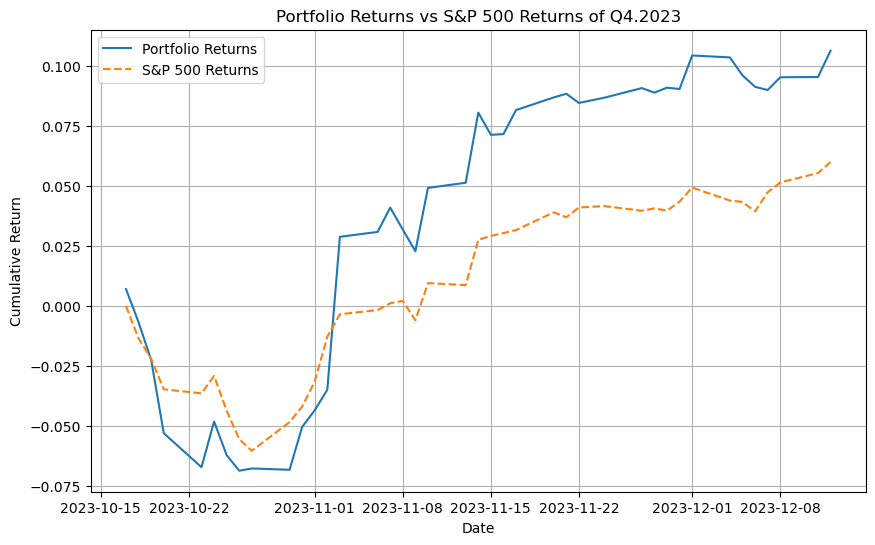

In [35]:
#Calculate S&P 500 return from 15/10/2023 to now
market_return = data.DataReader('^GSPC', start = '2023-10-15', end = '2023-12-13')['Adj Close']
port_ret['market_ret'] = np.log(market_return/market_return.shift(1))
#plot cumulative return of portfolio and S&P 500 Index
plt.figure(figsize=(10, 6))
plt.plot(port_ret['port_ret'].cumsum(), label='Portfolio Returns')
plt.plot(port_ret['market_ret'].cumsum(), label='S&P 500 Returns', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Returns vs S&P 500 Returns of Q4.2023')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
#Calculate standard deviation and max drawdown of portfolio and S&P 500 during investment horizon
import empyrical as ep
max_drawdown_port = ep.max_drawdown(port_ret['port_ret'])
max_drawdown_market = ep.max_drawdown(port_ret['market_ret'])
std_port = port_ret['port_ret'].std()
std_market = port_ret['market_ret'].std()
print(max_drawdown_port)
print(max_drawdown_market)
print(std_port)
print(std_market)

-0.0738908771747009
-0.05899207712165918
0.015145753834862408
0.007935241244943483


# Backtesting for Q3.2023

In [37]:
tech_list = []
date_q3 = pd.to_datetime('2023-06-30 00:00:00')
date_q2 = pd.to_datetime('2023-03-31 00:00:00')
for symbol in tech_stocks_list:
    balance_sheet_cols = yf.Ticker(symbol).quarterly_balancesheet.columns
    financials_cols = yf.Ticker(symbol).quarterly_financials.columns
    cashflow_cols = yf.Ticker(symbol).quarterly_cashflow.columns
    if any(len(cols) < 3 or cols[1] != date_q3 or cols[2] != date_q2 for cols in [balance_sheet_cols, financials_cols, cashflow_cols]):
        continue
    tech_list.append(symbol)
len(tech_list)

212

In [38]:
list_normal = []
list_unormal = []
required_index = ['Gross Profit', 'Depreciation And Amortization', 'Change In Working Capital', 'Free Cash Flow']
for symbol in tech_list:
    pnl = pd.DataFrame(yf.Ticker(symbol).quarterly_financials)
    bs = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet)
    cf = pd.DataFrame(yf.Ticker(symbol).quarterly_cashflow)
    
    fs = pd.concat([pnl, bs, cf]).fillna(0)
    
    if set(required_index).issubset(fs.index):
        list_normal.append(symbol)
    else:
        list_unormal.append(symbol)
len(list_normal)

205

In [39]:
inv_uni = []
for symbol in list_normal:
    equity_q3 = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet).loc['Stockholders Equity', '2023-06-30']
    equity_q2 = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet).loc['Stockholders Equity', '2023-03-31']
    if equity_q3 == 0 or equity_q2 == 0:
        continue
    else:
        inv_uni.append(symbol)
len(inv_uni)

205

In [40]:
#Profitability calculation
profitability_list=[]
for symbol in inv_uni:
    pnl = pd.DataFrame(yf.Ticker(symbol).quarterly_financials.loc[['Total Revenue','Net Income', 'Gross Profit'], '2023-06-30'])
    bs = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet.loc[['Total Assets', 'Stockholders Equity'], '2023-06-30'])
    cf = pd.DataFrame(yf.Ticker(symbol).quarterly_cashflow.loc[['Free Cash Flow', 'Depreciation And Amortization', 'Change In Working Capital'], '2023-06-30'])
    
    pnl.columns = [symbol]*len(pnl.columns)
    bs.columns = [symbol]*len(bs.columns)
    cf.columns = [symbol]*len(cf.columns)
    
    fs = pd.concat([pnl, bs, cf]).fillna(0)
    
    profitability = pd.DataFrame({
        'GOPA': fs.loc['Gross Profit']/(fs.loc['Total Assets']/4),
        'GMAR': fs.loc['Gross Profit']/fs.loc['Total Revenue'],
        'CFOA': fs.loc['Free Cash Flow']/(fs.loc['Total Assets']/4),
        'ROE': fs.loc['Net Income']/(fs.loc['Stockholders Equity']/4),
        'ROA': fs.loc['Net Income']/(fs.loc['Total Assets']/4),
        'ACC': (fs.loc['Depreciation And Amortization'] + fs.loc['Change In Working Capital'])/(fs.loc['Total Assets']/4)})
    profitability_list.append(profitability)
profitability_combined = pd.concat(profitability_list)

In [41]:
#Growth calculation
growth_list=[]
for symbol in inv_uni:
    pnl = pd.DataFrame(yf.Ticker(symbol).quarterly_financials).fillna(0)
    bs = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet).fillna(0)
    cf = pd.DataFrame(yf.Ticker(symbol).quarterly_cashflow).fillna(0)
    growth = pd.DataFrame({
        'g_GOPA': (pnl.loc['Gross Profit','2023-06-30']- pnl.loc['Gross Profit', '2023-03-31'])/(bs.loc['Total Assets', '2023-03-31']/4),
        'g_GMAR': (pnl.loc['Gross Profit','2023-06-30']- pnl.loc['Gross Profit', '2023-03-31'])/pnl.loc['Total Revenue', '2023-03-31'],
        'g_CFOA': (cf.loc['Free Cash Flow', '2023-06-30'] - cf.loc['Free Cash Flow', '2023-03-31'])/(bs.loc['Total Assets', '2023-03-31']/4),
        'g_ROE': (pnl.loc['Net Income', '2023-06-30'] - pnl.loc['Net Income', '2023-03-31'])/(bs.loc['Stockholders Equity', '2023-03-31']/4),
        'g_ROA': (pnl.loc['Net Income', '2023-06-30'] - pnl.loc['Net Income', '2023-03-31'])/(bs.loc['Total Assets','2023-03-31']/4)}, index =[symbol])
    growth_list.append(growth)
growth_combined = pd.concat(growth_list)

C:\Users\PV\AppData\Local\Temp\ipykernel_12388\2675364204.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  'g_ROE': (pnl.loc['Net Income', '2023-06-30'] - pnl.loc['Net Income', '2023-03-31'])/(bs.loc['Stockholders Equity', '2023-03-31']/4),


In [42]:
leverage_list={}
for symbol in inv_uni:
    bs = pd.DataFrame(yf.Ticker(symbol).quarterly_balancesheet).fillna(0)
    if set(['Long Term Debt', 'Current Debt']).issubset(bs.index):
        leverage = -(bs.loc['Long Term Debt', '2023-06-30'] + bs.loc['Current Debt', '2023-06-30'])/bs.loc['Total Assets', '2023-06-30']
        leverage_list[symbol] = leverage
    elif 'Long Term Debt' in bs.index and 'Current Debt' not in bs.index:
        leverage = -bs.loc['Long Term Debt', '2023-06-30']/bs.loc['Total Assets', '2023-06-30']
        leverage_list[symbol] = leverage
    elif 'Long Term Debt' not in bs.index and 'Current Debt' in bs.index:
        leverage = -bs.loc['Current Debt', '2023-06-30']/bs.loc['Total Assets', '2023-06-30']
        leverage_list[symbol] = leverage
    else:
        leverage_list[symbol] = 0
leverage_combined = pd.DataFrame(leverage_list, index = ['LEV'])

In [43]:
metrics = pd.concat([profitability_combined, growth_combined], axis = 1)
metrics['LEV'] = leverage_combined.T.values

In [44]:
#Calculate standard deviation of S&P 500 Index
from pandas_datareader import data, wb
from datetime import datetime, timedelta
yf.pdr_override()
market_data = data.DataReader('^GSPC', start = '2022-07-15', end = '2023-07-15')['Adj Close']
logret_market = np.log(market_data/market_data.shift(1))
market_std = np.std(logret_market)
print(market_std)

[*********************100%%**********************]  1 of 1 completed
0.012077473325287783


In [45]:
asset_std_list = []
correlation_list = []
market_data_5year = data.DataReader('^GSPC', start = '2018-07-15', end = '2023-07-15')['Adj Close']
market_ret = np.log(market_data_5year/market_data_5year.shift(3))
for symbol in inv_uni:
    asset_data_1year = data.DataReader(symbol, start = '2022-07-15', end = '2023-07-15')['Adj Close']
    asset_data_5year = data.DataReader(symbol, start = '2018-07-15', end = '2023-07-15')['Adj Close']
    asset_std = np.std(np.log(asset_data_1year/asset_data_1year.shift(1)))
    asset_ret = np.log(asset_data_5year/asset_data_5year.shift(3))
    correlation = asset_ret.corr(market_ret)
    asset_std_list.append(asset_std)
    correlation_list.append(correlation)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [46]:
metrics['BAB'] = [-x*y/market_std for x,y in zip(asset_std_list, correlation_list)]
ranked_metrics = metrics.rank(method = 'min')

In [47]:
#scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit and transform the data
scaled_metrics = scaler.fit_transform(ranked_metrics)
scaled_ranked_metrics = pd.DataFrame(scaled_metrics, columns=ranked_metrics.columns, index = ranked_metrics.index)

C:\Users\PV\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\PV\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\PV\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\PV\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [48]:
#Caculate z score of profitability, growth, safety and quality score
scaled_ranked_metrics['z_profitability'] = scaled_ranked_metrics.iloc[:,0:6].mean(axis = 1)
scaled_ranked_metrics['z_growth'] = scaled_ranked_metrics.iloc[:,6:11].mean(axis = 1)
scaled_ranked_metrics['z_safety'] = scaled_ranked_metrics.iloc[:,11:].mean(axis = 1)
scaled_ranked_metrics['q_score'] = (scaled_ranked_metrics['z_profitability'] + scaled_ranked_metrics['z_growth'] + scaled_ranked_metrics['z_safety'])/3 

In [49]:
top_5 = scaled_ranked_metrics.nlargest(5, 'q_score')
top_5

,GOPA,GMAR,CFOA,ROE,ROA,ACC,g_GOPA,g_GMAR,g_CFOA,g_ROE,g_ROA,LEV,BAB,z_profitability,z_growth,z_safety,q_score
META,1.199960,1.368844,1.369001,0.929570,1.301401,1.470369,1.554875,1.537928,1.233735,0.828145,1.132361,0.767392,-0.946302,1.273191,1.257409,0.587922,1.039507
QLYS,1.385856,1.284353,1.588703,1.521062,1.538005,0.304280,1.284476,0.895751,-1.064577,1.047835,1.047863,1.201912,0.996997,1.270377,0.642270,1.027889,0.980178
JKHY,0.135280,-0.658951,1.216899,1.014069,1.183100,1.419670,1.166177,0.777455,1.656219,0.591556,0.709869,0.672931,1.385657,0.718344,0.980255,0.939297,0.879299
GOOGL,1.014063,0.016981,1.402801,1.081668,1.419703,1.132372,1.183077,0.811254,0.777453,0.692951,1.014063,1.088559,-0.202779,1.011265,0.895759,0.698201,0.868408
GOOG,1.014063,0.016981,1.402801,1.081668,1.419703,1.132372,1.183077,0.811254,0.777453,0.692951,1.014063,1.088559,-0.236576,1.011265,0.895759,0.689752,0.865592


In [50]:
symbols = top_5.index
noa = len(symbols)

d = pd.DataFrame()
#download and add it to the dataframe
for sym in symbols:
    d[sym] = data.DataReader(sym,start = '2020-07-15', end = '2023-07-15')['Adj Close']
    
d.columns = symbols
d

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,META,QLYS,JKHY,GOOGL,GOOG
Date,,,,,
2020-07-15,240.279999,109.739998,178.090530,75.844002,75.681999
2020-07-16,240.929993,106.230003,176.795380,75.746002,75.900002
2020-07-17,242.029999,108.489998,179.524094,75.842499,75.777496
2020-07-20,245.419998,113.500000,180.779739,78.192001,78.286003
2020-07-21,241.750000,112.849998,181.204834,77.795998,77.920998
...,...,...,...,...,...
2023-07-10,294.100006,129.199997,163.220001,116.449997,116.870003
2023-07-11,298.290009,127.110001,164.830002,117.139999,117.709999
2023-07-12,309.339996,128.089996,165.279999,118.930000,119.620003


In [51]:
rets = np.log(d / d.shift(1))
print(rets.mean() * 252)
print(rets.cov() * 252)
#252 anuualizing returns. to get the annual mean
#mean
#covariance of the stocks. #negative no rlship. #0 no covariance # covariance = volatility

def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])
#portfolio return
#portfolio volatility
#sharpe ratio

import scipy.optimize as sco
def min_func_sharpe(weights):
    return -statistics(weights)[2]
# the '-' (negative sign) is to specify MINIMIZATION
def sum_constraint(x):
    return np.sum(x) - 1
#If I sum the weights should bring 100%
def max_weight_constraint(x):
    return 0.4 - np.max(x)
#weight in a security should not exceed 40%

cons = ({'type': 'eq', 'fun': sum_constraint}, {'type':'ineq','fun': max_weight_constraint})
# constraint where sum should be 1 ('eq') and also maximum weight constraint not be equal to 0.4
# fun is the objective function
bnds = tuple((0, 1) for x in range(noa))
# Setting optimization variables to be in range 0 and 1
noa * [1. / noa,]
#noa number of assets, defined above as length of the stock, 5
# the answer obtained in th bracket, replicate 5 times and not multiply 5 times

META     0.083927
QLYS     0.054767
JKHY    -0.021990
GOOGL    0.168108
GOOG     0.169568
dtype: float64
           META      QLYS      JKHY     GOOGL      GOOG
META   0.241075  0.071126  0.031965  0.098981  0.099093
QLYS   0.071126  0.191238  0.034007  0.052658  0.052254
JKHY   0.031965  0.034007  0.072098  0.029404  0.029614
GOOGL  0.098981  0.052658  0.029404  0.101690  0.100982
GOOG   0.099093  0.052254  0.029614  0.100982  0.101565


[0.2, 0.2, 0.2, 0.2, 0.2]

In [52]:
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)

weight = opts['x'].round(3)
#this weights will give the best sharpe ratio

print(weight)

[0.012 0.18  0.008 0.4   0.4  ]


In [53]:
d_test = pd.DataFrame()
#download and add it to the dataframe
for sym in symbols:
    d_test[sym] = data.DataReader(sym,start = '2023-07-15', end = '2023-10-15')['Adj Close']    
d_test.columns = symbols
for sym in symbols:
    d_test['logret'+sym] = np.log(d_test[sym]/d_test[sym].shift(1))
d_test

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,META,QLYS,JKHY,GOOGL,GOOG,logretMETA,logretQLYS,logretJKHY,logretGOOGL,logretGOOG
Date,,,,,,,,,,
2023-07-17,310.619995,130.240005,168.320007,124.650002,125.059998,NaN,NaN,NaN,NaN,NaN
2023-07-18,312.049988,131.869995,170.070007,123.760002,124.080002,0.004593,0.012438,0.010343,-0.007166,-0.007867
2023-07-19,316.010010,132.820007,172.759995,122.029999,122.779999,0.012610,0.007178,0.015693,-0.014077,-0.010532
2023-07-20,302.519989,131.039993,171.929993,119.199997,119.529999,-0.043627,-0.013492,-0.004816,-0.023464,-0.026827
2023-07-21,294.260010,131.110001,171.610001,120.019997,120.309998,-0.027684,0.000534,-0.001863,0.006856,0.006504
...,...,...,...,...,...,...,...,...,...,...
2023-10-09,318.359985,161.229996,147.800003,138.419998,139.500000,0.009246,0.001614,-0.007885,0.006087,0.005535
2023-10-10,321.839996,163.490005,148.820007,138.059998,139.199997,0.010872,0.013920,0.006878,-0.002604,-0.002153
2023-10-11,327.820007,162.009995,147.179993,140.550003,141.699997,0.018410,-0.009094,-0.011081,0.017875,0.017800


In [54]:
port_ret = d_test.iloc[:, 5:]
port_ret['port_ret'] = (port_ret.values * weight).sum(axis =1)
port_ret

,logretMETA,logretQLYS,logretJKHY,logretGOOGL,logretGOOG,port_ret
Date,,,,,,
2023-07-17,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-18,0.004593,0.012438,0.010343,-0.007166,-0.007867,-0.003636
2023-07-19,0.012610,0.007178,0.015693,-0.014077,-0.010532,-0.008275
2023-07-20,-0.043627,-0.013492,-0.004816,-0.023464,-0.026827,-0.023107
2023-07-21,-0.027684,0.000534,-0.001863,0.006856,0.006504,0.005093
...,...,...,...,...,...,...
2023-10-09,0.009246,0.001614,-0.007885,0.006087,0.005535,0.004987
2023-10-10,0.010872,0.013920,0.006878,-0.002604,-0.002153,0.000788
2023-10-11,0.018410,-0.009094,-0.011081,0.017875,0.017800,0.012766


[*********************100%%**********************]  1 of 1 completed


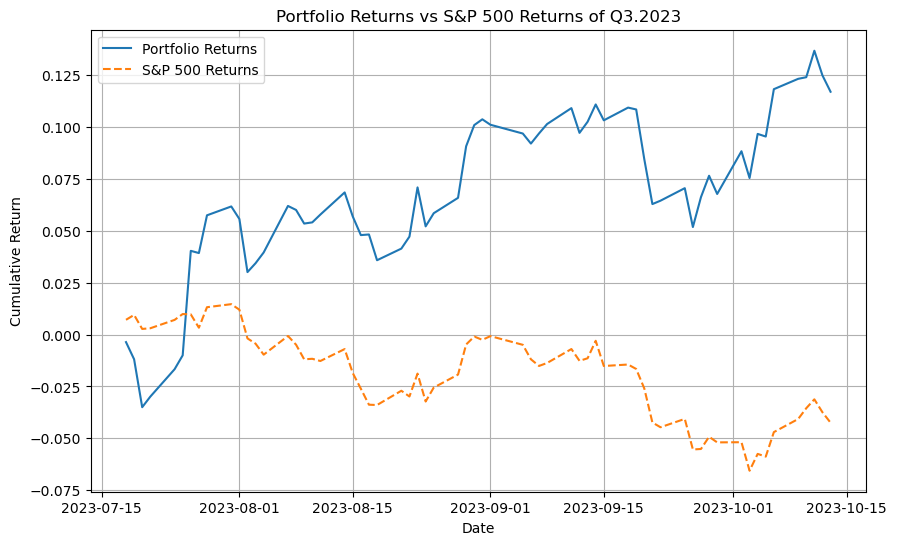

In [55]:
#Calculate S&P 500 return from 15/07/2023 to 15/10/2023
market_return = data.DataReader('^GSPC', start = '2023-07-15', end = '2023-10-15')['Adj Close']
port_ret['market_ret'] = market_return/market_return.shift(1) - 1
#plot cumulative return of portfolio and S&P 500 Index
plt.figure(figsize=(10, 6))
plt.plot(port_ret['port_ret'].cumsum(), label='Portfolio Returns')
plt.plot(port_ret['market_ret'].cumsum(), label='S&P 500 Returns', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Returns vs S&P 500 Returns of Q3.2023')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
max_drawdown_port = ep.max_drawdown(port_ret['port_ret'])
max_drawdown_market = ep.max_drawdown(port_ret['market_ret'])
std_port = port_ret['port_ret'].std()
std_market = port_ret['market_ret'].std()
print(max_drawdown_port)
print(max_drawdown_market)
print(std_port)
print(std_market)

-0.05812106945583863
-0.07834231910612584
0.013558597012904142
0.0071205398202842315
